# CASA0007 QM Coursework 3

Combine the categories of self-reported health

In [2]:
# Import library

import numpy as np
import pandas as pd
import os
import re
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from statsmodels.tools.tools import add_constant
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from math import log

## Regression 1: Well-being scores against NDVI

### Well-being scores

Read in dependent variables - well-being scores. I am using the data from 2011/12 as the available data on health ratings and age are from 2011 census.

In [3]:
# Read well-being
wellbeing = pd.read_excel(os.path.join(os.getcwd(), 'Data', 'personal-well-being-borough.xlsx'),
                         sheet_name = 'Summary - Mean Scores', skiprows = 1)

# Rename and keep useful columns
cols = ['Life Satisfaction', 'Worthwhile', 'Happiness', 'Anxiety']
year = '2011/12'
wellbeing.rename({year: cols[0],
                 year+'.1': cols[1],
                 year+'.2': cols[2],
                 year+'.3': cols[3]},
                axis = 1, inplace = True)
wellbeing = wellbeing[['Code', 'Area'] + cols]

# Keep only data on London boroughs (Area Code starts with E09)
wellbeing.dropna(axis = 0, inplace = True)
wellbeing.drop(wellbeing[wellbeing.Area == "City of London"].index, inplace = True)
wellbeing = wellbeing[wellbeing['Code'].str.match(r'E09')].sort_values(by = ['Code'], ascending=True)
wellbeing = wellbeing.reset_index(drop = True)

# Set data type
wellbeing[cols] = wellbeing[cols].astype('float', copy = False)


In [4]:
wellbeing

,Code,Area,Life Satisfaction,Worthwhile,Happiness,Anxiety
0,E09000002,Barking and Dagenham,7.05,7.49,6.91,3.23
1,E09000003,Barnet,7.43,7.70,7.26,3.41
2,E09000004,Bexley,7.42,7.68,7.22,3.07
3,E09000005,Brent,7.11,7.20,7.07,2.77
4,E09000006,Bromley,7.50,7.84,7.44,3.30
5,E09000007,Camden,7.25,7.35,7.24,3.81
6,E09000008,Croydon,7.04,7.57,7.21,3.47
7,E09000009,Ealing,7.22,7.62,7.01,3.86
8,E09000010,Enfield,7.23,7.57,7.16,3.15
9,E09000011,Greenwich,7.18,7.36,7.08,3.38


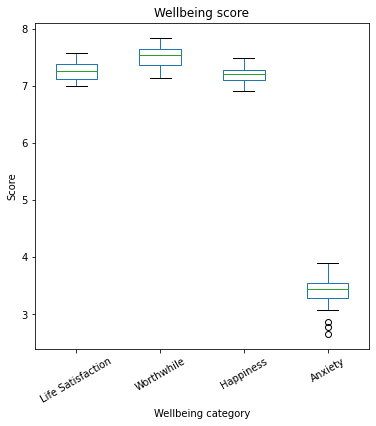

In [5]:
plt.figure(figsize=(6, 6))
plt.title('Wellbeing score')
plt.xlabel('Wellbeing category')
plt.ylabel('Score')
plt1 = wellbeing.boxplot(['Life Satisfaction', 'Worthwhile', 'Happiness', 'Anxiety'], 
                  grid = False, rot = 30, widths = 0.5)


Read in independent variables - NDVI, self-reported health, age. Other variables added in to control for them, based on study done by ONS (these are those with at least moderate effect on well-being score) and availability of data.

Self-reported health and age are from 2011 census, but NDVI is collected in 2019. An alternative is to look at the land use data, but there seems to be a data gap between 2005 (?) and 2018. 2018 data is also not very suitable as urban greenery is not a category on its own - they may be subsumed under other land uses. Should be ok to use NDVI data from 2019, since green cover may not change very fast as part of the built environment (??).

### NDVI

In [6]:
# Read NDVI
ndvi = pd.read_excel(os.path.join(os.getcwd(), 'Data', 'green_cover_borough_summary_0.05.xlsx'),
                         sheet_name = 'borough_green_cover')

# Rename and keep useful columns
ndvi = ndvi[['lb_code', 'lb_name', 'percent_green']]

# Drop City of London
ndvi.drop(ndvi[ndvi.lb_code == 'City of London'].index, inplace = True)
ndvi = ndvi.reset_index(drop = True)

# Change name of 'City of Westminster' to Westminster
ndvi.loc[ndvi[ndvi.lb_code == 'City of Westminster'].index, 'lb_code'] = 'Westminster'

In [7]:
ndvi

,lb_code,lb_name,percent_green
0,Barking and Dagenham,E09000002,39.201168
1,Barnet,E09000003,57.994299
2,Bexley,E09000004,42.918334
3,Brent,E09000005,39.936406
4,Bromley,E09000006,68.356138
5,Camden,E09000007,43.278949
6,Croydon,E09000008,55.527790
7,Ealing,E09000009,43.958704
8,Enfield,E09000010,52.952754
9,Greenwich,E09000011,43.219748


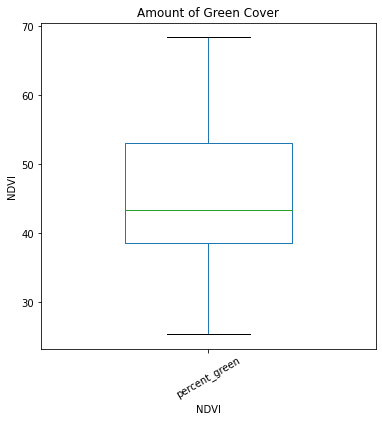

In [8]:
plt.figure(figsize=(6, 6))
plt.title('Amount of Green Cover')
plt.xlabel('NDVI')
plt.ylabel('NDVI')
plt1 = ndvi.boxplot(['percent_green'], 
                  grid = False, rot = 30, widths = 0.5)

### Age and health

In [10]:
# Read self-reported health and age profile
age_cols = ['Age Structure (2011 Census);0-15;',
            'Age Structure (2011 Census);16-29;',
            'Age Structure (2011 Census);30-44;',
            'Age Structure (2011 Census);45-64;',
            'Age Structure (2011 Census);65+;']
health_cols = ['Health (2011 Census);Very good health;',
              'Health (2011 Census);Good health;',
              'Health (2011 Census);Fair health;',
              'Health (2011 Census);Bad health;',
              'Health (2011 Census);Very bad health;']
age_health = pd.read_csv(os.path.join(os.getcwd(), 'Data', 'msoa-data.csv'),
                         usecols = ['Middle Super Output Area', 'MSOA Name',
                                    'Age Structure (2011 Census);All Ages;'] + age_cols + health_cols, 
                         low_memory = False, encoding = 'latin')

# Drop row on average for London and City of London
age_health.dropna(axis = 0, inplace = True)
age_health.drop(age_health[age_health['MSOA Name'] == 'City of London 001'].index, inplace = True)
age_health.reset_index(inplace = True)

# Change data type
age_health[age_cols] = age_health[age_cols].astype('int', copy = False)
age_health[health_cols] = age_health[health_cols].astype('int', copy = False)

# Drop numbers (last 4 characters) from MSOA name
for i in range(0, age_health.shape[0]):
               age_health['MSOA Name'][i] = age_health['MSOA Name'][i][:-4]

# Compute total number of respondents in MSOA
respondents = age_health.groupby('MSOA Name').agg({'Age Structure (2011 Census);All Ages;': np.sum}).reset_index()

# Compute number and percentage of respondents in each age group
age = age_health.groupby('MSOA Name').agg(dict.fromkeys(age_cols, np.sum)).reset_index()
age[age_cols] = age[age_cols].div(respondents['Age Structure (2011 Census);All Ages;'], axis = 0) * 100

# Compute number and percentage of respondents in each health category
health = age_health.groupby('MSOA Name').agg(dict.fromkeys(health_cols, np.sum)).reset_index()
health[health_cols] = health[health_cols].div(respondents['Age Structure (2011 Census);All Ages;'], axis = 0) * 100

# Rename columns for easy reference
age.rename({age_cols[0]: 'Age_0-15',
           age_cols[1]: 'Age_15-29',
           age_cols[2]: 'Age_30-44',
           age_cols[3]: 'Age_45-64',
           age_cols[4]: 'Age_65+'},
          axis = 1, inplace = True)
health.rename({health_cols[0]: 'Very_good',
               health_cols[1]: 'Good',
               health_cols[2]: 'Fair',
               health_cols[3]: 'Bad',
               health_cols[4]: 'Very_bad'},
              axis = 1, inplace = True)

# Combine health categories
health.Good = health.Very_good + health.Good
health.Bad = health.Very_bad + health.Bad
health.drop(['Very_good', 'Very_bad'], axis = 1, inplace = True)

/tmp/ipykernel_2646/1800370840.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  age_health['MSOA Name'][i] = age_health['MSOA Name'][i][:-4]


In [11]:
age

,MSOA Name,Age_0-15,Age_15-29,Age_30-44,Age_45-64,Age_65+
0,Barking and Dagenham,25.979098,20.480230,23.378391,19.769675,10.392607
1,Barnet,20.829662,20.081597,23.531789,22.247788,13.309165
2,Bexley,20.502851,17.823506,20.321815,25.311965,16.039863
3,Brent,20.165159,23.701942,24.512957,21.120447,10.499494
4,Bromley,19.582277,15.546620,22.021255,26.030731,16.819116
5,Camden,16.095726,26.551934,27.037098,19.433325,10.881918
6,Croydon,21.770718,19.246350,22.686844,24.084287,12.211801
7,Ealing,20.350777,21.628074,25.837275,21.480046,10.703828
8,Enfield,22.402757,20.143312,22.461644,22.564375,12.427912
9,Greenwich,21.760942,21.614412,25.764367,20.600887,10.259392


In [12]:
health

,MSOA Name,Good,Fair,Bad
0,Barking and Dagenham,80.973692,12.931994,6.094314
1,Barnet,84.448042,10.991453,4.560505
2,Bexley,82.660121,12.506627,4.833252
3,Brent,82.857189,11.802452,5.340360
4,Bromley,84.220665,11.667399,4.111936
5,Camden,83.973713,10.421716,5.604571
6,Croydon,83.444237,11.963575,4.592188
7,Ealing,83.645394,11.352080,5.002526
8,Enfield,81.847305,12.705062,5.447633
9,Greenwich,83.091803,11.543976,5.364221


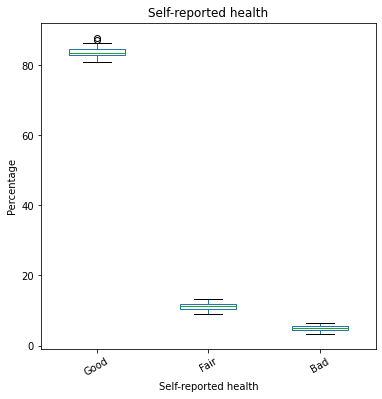

In [13]:
plt.figure(figsize=(6, 6))
plt.title('Self-reported health')
plt.xlabel('Self-reported health')
plt.ylabel('Percentage')
plt1 = health.boxplot(['Good', 'Fair', 'Bad'], 
                  grid = False, rot = 30, widths = 0.5)

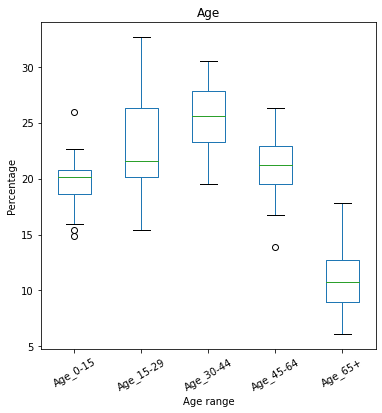

In [14]:
plt.figure(figsize=(6, 6))
plt.title('Age')
plt.xlabel('Age range')
plt.ylabel('Percentage')
plt1 = age.boxplot(['Age_0-15', 'Age_15-29', 'Age_30-44', 'Age_45-64', 'Age_65+'], 
                  grid = False, rot = 30, widths = 0.5)

### Economic activity

In [15]:
# Read economic inactivity and rename columns for easy reference
econ_cols = ['Code', 'Area', 'percent; Jan 2018-Dec 2018']
economic = pd.read_csv(os.path.join(os.getcwd(), 'Data', 'economic-inactivity.csv'),
                         usecols = econ_cols, 
                         low_memory = False, encoding = 'latin')
economic.rename({econ_cols[2]: 'Econ_inactive'}, axis = 1, inplace = True)

# Keep only data on London boroughs (Area Code starts with E09), drop City of London and change data type
economic.dropna(axis = 0, inplace = True)
economic = economic[economic['Code'].str.match(r'E09')].sort_values(by = ['Code'], ascending=True)
economic.drop(economic[economic.Area == 'City of London'].index, inplace = True)
economic = economic.reset_index(drop = True)
economic.Econ_inactive = economic.Econ_inactive.astype('float', copy = False)

In [16]:
# Read unemployment rate
unemployment = pd.read_excel(os.path.join(os.getcwd(), 'Data', 'mb-unemployment-rates.xlsx'),
                           sheet_name = 'Rates')

# Get unemployment rates in 2011
unemployment = unemployment[['Code', 'Area', 'Jan 2011-Dec 2011']]

# Keep only data on London boroughs (Area Code starts with E09), drop City of London and change data type
unemployment.dropna(axis = 0, inplace = True)
unemployment = unemployment[unemployment['Code'].str.match(r'E09')].sort_values(by = ['Code'], ascending=True)
unemployment.drop(unemployment[unemployment.Area == 'City of London'].index, inplace = True)
unemployment = unemployment.reset_index(drop = True)
unemployment['Jan 2011-Dec 2011'] = unemployment['Jan 2011-Dec 2011'].astype('float', copy = False)

In [17]:
# Compute unemployment rate among economically active
economic['Unemployed'] = ((100 - economic.Econ_inactive)/100) * (unemployment['Jan 2011-Dec 2011']/100) * 100

# Compute employment rate among economically active
economic['Employed'] = 100 - economic.Econ_inactive - economic.Unemployed

In [18]:
economic

,Code,Area,Econ_inactive,Unemployed,Employed
0,E09000002,Barking and Dagenham,27.0,9.490,63.510
1,E09000003,Barnet,24.0,6.080,69.920
2,E09000004,Bexley,21.0,6.320,72.680
3,E09000005,Brent,25.0,8.100,66.900
4,E09000006,Bromley,18.0,5.658,76.342
5,E09000007,Camden,24.0,6.688,69.312
6,E09000008,Croydon,21.0,8.532,70.468
7,E09000009,Ealing,21.0,7.900,71.100
8,E09000010,Enfield,27.0,8.760,64.240
9,E09000011,Greenwich,24.0,8.208,67.792


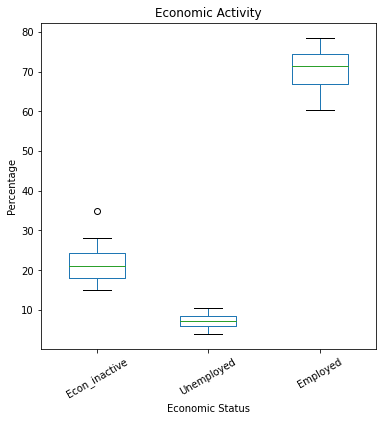

In [19]:
plt.figure(figsize=(6, 6))
plt.title('Economic Activity')
plt.xlabel('Economic Status')
plt.ylabel('Percentage')
plt1 = economic.boxplot(['Econ_inactive', 'Unemployed', 'Employed'], 
                  grid = False, rot = 30, widths = 0.5)

### Regressions

In [20]:
# Merge independent variables
ind_var = pd.merge(health, age, on = 'MSOA Name')
ind_var = ind_var.merge(economic[['Area','Econ_inactive','Unemployed','Employed']],
                        left_on = 'MSOA Name', right_on = 'Area').drop('Area', axis = 1)
ind_var = ind_var.merge(ndvi[['lb_code','percent_green']],
                        left_on = 'MSOA Name', right_on = 'lb_code').drop('lb_code', axis = 1)


#ind_var.drop(['Very_bad','Age_65+'], axis = 1, inplace = True)

In [21]:
ind_var.head()

,MSOA Name,Good,Fair,Bad,Age_0-15,Age_15-29,Age_30-44,Age_45-64,Age_65+,Econ_inactive,Unemployed,Employed,percent_green
0,Barking and Dagenham,80.973692,12.931994,6.094314,25.979098,20.480230,23.378391,19.769675,10.392607,27.0,9.490,63.510,39.201168
1,Barnet,84.448042,10.991453,4.560505,20.829662,20.081597,23.531789,22.247788,13.309165,24.0,6.080,69.920,57.994299
2,Bexley,82.660121,12.506627,4.833252,20.502851,17.823506,20.321815,25.311965,16.039863,21.0,6.320,72.680,42.918334
3,Brent,82.857189,11.802452,5.340360,20.165159,23.701942,24.512957,21.120447,10.499494,25.0,8.100,66.900,39.936406
4,Bromley,84.220665,11.667399,4.111936,19.582277,15.546620,22.021255,26.030731,16.819116,18.0,5.658,76.342,68.356138


In [22]:
# Define function to drop variables using VIF
# This function is adjusted from: https://stackoverflow.com/a/51329496/4667568

def drop_column_using_vif_(df, thresh=5):
    '''
    Calculates VIF each feature in a pandas dataframe, and repeatedly drop the columns with the highest VIF
    A constant must be added to variance_inflation_factor or the results will be incorrect

    :param df: the pandas dataframe containing only the predictor features, not the response variable
    :param thresh: (default 5) the threshould VIF value. If the VIF of a variable is greater than thresh, it should be removed from the dataframe
    :return: dataframe with multicollinear features removed
    '''
    while True:
        # adding a constatnt item to the data
        df_with_const = add_constant(df)

        vif_df = pd.Series([variance_inflation_factor(df_with_const.values, i) 
               for i in range(df_with_const.shape[1])], name= "VIF",
              index=df_with_const.columns).to_frame()

        # drop the const
        vif_df = vif_df.drop('const')
        
        # if the largest VIF is above the thresh, remove a variable with the largest VIF
        # If there are multiple variabels with VIF>thresh, only one of them is removed. This is because we want to keep as many variables as possible
        if vif_df.VIF.max() > thresh:
            # If there are multiple variables with the maximum VIF, choose the first one
            index_to_drop = vif_df.index[vif_df.VIF == vif_df.VIF.max()].tolist()[0]
            print('Dropping: {}'.format(index_to_drop))
            df = df.drop(columns = index_to_drop)
        else:
            # No VIF is above threshold. Exit the loop
            break

    return df

In [23]:
# Define function to perform backwards regression using P-VALUE as selection criterion

def back_regress_p(df_dep, df_ind, thresh=0.05):
    '''
    Performs regression with backwards selection of variables using AIC as selection criterion.

    :param df_dep, df_ind: the pandas dataframe containing dependent variable and indepdendent variables respectively.
    :return: the final regression model
    '''    
    
    print('P-VALUE')
    
    # Initialize index_to_drop
    index_to_drop = []
    
    while True:
        # Get variables
        var = df_ind.columns.values.tolist()
        
        # Perform regressions
        if index_to_drop == 'const':
            reg_model = sm.OLS(endog=df_dep, exog=df_ind).fit()
        else:
            reg_model = sm.OLS(endog=df_dep, exog=sm.add_constant(df_ind)).fit()
        
        # Find p-values for all variables
        df_pval = reg_model.pvalues
        #df_pval = pd.Series([reg_model.pvalues[i] for i in var], name='pvalue', index = var).to_frame()
        
        # If best (lowest) new AIC is lower than the current best, remove variable that improves AIC the most
        if df_pval.max() > thresh:
            # If there are multiple variables with best new AIC, choose the first one
            index_to_drop = df_pval.index[df_pval == df_pval.max()].tolist()[0]
            print('Dropping: {}'.format(index_to_drop))
            # Drop variable from df_ind
            if index_to_drop != 'const':
                df_ind = df_ind.drop(columns = index_to_drop)
        else:
            break
            
    # Perform regression with final set of variables
    if index_to_drop == 'const':
        reg_model = sm.OLS(endog=df_dep, exog=df_ind).fit()
    else:
        reg_model = sm.OLS(endog=df_dep, exog=sm.add_constant(df_ind)).fit()
    
    return reg_model

In [24]:
# Define function to perform backwards regression using AIC as selection criterion

def back_regress_aic(df_dep, df_ind):
    '''
    Performs regression with backwards selection of variables using AIC as selection criterion.

    :param df_dep, df_ind: the pandas dataframe containing dependent variable and indepdendent variables respectively.
    :return: the final regression model
    '''    

    print('AIC!!!')
    
    # Perform regression with all variables
    best_aic = sm.OLS(endog=df_dep, exog=sm.add_constant(df_ind)).fit().aic
    
    # Initialize index_to_drop
    index_to_drop = []
    
    while True:
        # Get variables
        var = df_ind.columns.values.tolist()
        
        # Perform regressions with one variable dropped at a time and find AIC
        if index_to_drop == 'const':
            df_aic = pd.Series([sm.OLS(endog=df_dep, exog=df_ind.drop(columns = var_test)).fit().aic 
                            for var_test in var], name='AIC', index = var).to_frame()
        else:
            df_aic = pd.Series([sm.OLS(endog=df_dep, exog=sm.add_constant(df_ind.drop(columns = var_test))).fit().aic 
                                for var_test in var], name='AIC', index = var).to_frame()
        
        # If best (lowest) new AIC is lower than the current best, remove variable that improves AIC the most
        best_new_aic = df_aic.AIC.min()
        if best_new_aic < best_aic:
            # If there are multiple variables with best new AIC, choose the first one
            index_to_drop = df_aic.index[df_aic.AIC == best_new_aic].tolist()[0]
            print('Dropping: {}'.format(index_to_drop))
            # Drop variable from df_ind
            if index_to_drop != 'const':
                df_ind = df_ind.drop(columns = index_to_drop)
            # Update the best AIC
            best_aic = best_new_aic
        else:
            break
            
    # Perform regression with final set of variables
    if index_to_drop == 'const':
        reg_model = sm.OLS(endog=df_dep, exog=df_ind).fit()
    else:
        reg_model = sm.OLS(endog=df_dep, exog=sm.add_constant(df_ind)).fit()
    
    return reg_model

In [25]:
# Drop collinear independent variables
ind_var_clean = drop_column_using_vif_(ind_var.drop('MSOA Name', axis=1))

Dropping: Good
Dropping: Age_0-15
Dropping: Econ_inactive
Dropping: Age_65+
Dropping: Fair
Dropping: Age_45-64


/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1738: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


In [26]:
ind_var_clean

,Bad,Age_15-29,Age_30-44,Unemployed,Employed,percent_green
0,6.094314,20.480230,23.378391,9.490,63.510,39.201168
1,4.560505,20.081597,23.531789,6.080,69.920,57.994299
2,4.833252,17.823506,20.321815,6.320,72.680,42.918334
3,5.340360,23.701942,24.512957,8.100,66.900,39.936406
4,4.111936,15.546620,22.021255,5.658,76.342,68.356138
5,5.604571,26.551934,27.037098,6.688,69.312,43.278949
6,4.592188,19.246350,22.686844,8.532,70.468,55.527790
7,5.002526,21.628074,25.837275,7.900,71.100,43.958704
8,5.447633,20.143312,22.461644,8.760,64.240,52.952754
9,5.364221,21.614412,25.764367,8.208,67.792,43.219748


PERFORMING REGRESSION ON:Life satisfaction
P-VALUE
Dropping: Age_15-29
Dropping: percent_green
Dropping: Age_30-44
Dropping: Employed
Dropping: Bad
                            OLS Regression Results                            
Dep. Variable:      Life Satisfaction   R-squared:                       0.596
Model:                            OLS   Adj. R-squared:                  0.582
Method:                 Least Squares   F-statistic:                     44.22
Date:                Wed, 05 Jan 2022   Prob (F-statistic):           2.31e-07
Time:                        17:18:38   Log-Likelihood:                 28.031
No. Observations:                  32   AIC:                            -52.06
Df Residuals:                      30   BIC:                            -49.13
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0

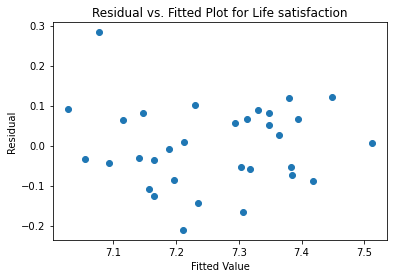



PERFORMING REGRESSION ON:Worthwhile
P-VALUE
Dropping: Age_30-44
Dropping: percent_green
Dropping: Employed
Dropping: Bad
                            OLS Regression Results                            
Dep. Variable:             Worthwhile   R-squared:                       0.584
Model:                            OLS   Adj. R-squared:                  0.555
Method:                 Least Squares   F-statistic:                     20.34
Date:                Wed, 05 Jan 2022   Prob (F-statistic):           3.01e-06
Time:                        17:18:38   Log-Likelihood:                 26.064
No. Observations:                  32   AIC:                            -46.13
Df Residuals:                      29   BIC:                            -41.73
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------

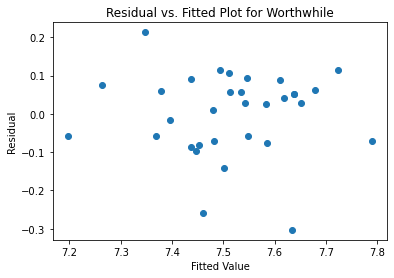



PERFORMING REGRESSION ON:Happiness
P-VALUE
Dropping: Age_30-44
Dropping: Bad
Dropping: Age_15-29
Dropping: percent_green
Dropping: Employed
                            OLS Regression Results                            
Dep. Variable:              Happiness   R-squared:                       0.368
Model:                            OLS   Adj. R-squared:                  0.347
Method:                 Least Squares   F-statistic:                     17.44
Date:                Wed, 05 Jan 2022   Prob (F-statistic):           0.000235
Time:                        17:18:38   Log-Likelihood:                 25.898
No. Observations:                  32   AIC:                            -47.80
Df Residuals:                      30   BIC:                            -44.87
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025  

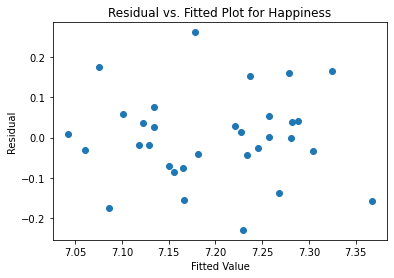

In [28]:
wellbeing_cat = ['Life Satisfaction', 'Worthwhile', 'Happiness']

# Perform regression
for cat in wellbeing_cat:
    print(f'PERFORMING REGRESSION ON:{cat.capitalize()}')
    
    # Perform regression
    #reg_model = back_regress_aic(wellbeing[cat], ind_var_clean)
    reg_model = back_regress_p(wellbeing[cat], ind_var_clean)
    #reg_model = sm.OLS(endog=wellbeing[cat], exog=sm.add_constant(ind_var_clean)).fit()
    print(reg_model.summary())

    # plot residual vs. fit
    plt.scatter(reg_model.fittedvalues, reg_model.resid)
    plt.xlabel('Fitted Value')
    plt.ylabel('Residual')
    plt.title('Residual vs. Fitted Plot for ' + cat.capitalize())
    plt.show()
    print('\n')
    

From regression above, urban greenery has significant relationship with happiness only. Positive relationship as expected - one percentage point increase in NDVI, 0.007 increase in happiness score.

Compare with lit: White found that life satisfaction and worth were statistically significant. May be because we use different measures of greenery - White used greenspace as 300m from households.

To check: negative relationship between 'happiness' and 'good' health is weird. If I use happiness data from 2018/19, then positive relationship between 'happiness' and 'good' health, and negative relationship with 'very bad' health achieved, as expected. But negative relationship with greenery, which is unexpected.

## Regression 2: Mediators against NDVI

Four mediators from literature: Physical exercise, air quality and noise, self-reported stress, and social cohesion.

Due to lack of data, I am unable to look at social cohesion. Also, I will only be looking at objective air quality.

### Physical activity

In [28]:
# Read in physical exercise (from 2012)
url = 'https://github.com/ngliangwei15/CASA0007-CW3/blob/main/Data/LSD21-APS-Physical-Activity-Levels.xlsx?raw=true'
exercise = pd.read_excel(url, sheet_name = '2012')

# Rename and keep useful columns
cols = ['GSS_Code', 'Region', 'Active']
exercise = exercise[cols]

# Keep only data on London boroughs (Area Code starts with E09)
exercise = exercise[exercise['GSS_Code'].str.match(r'E09')].sort_values(by = ['GSS_Code'], ascending=True)
exercise = exercise.reset_index(drop = True)

# Convert 'Active' to percentage
exercise.Active = exercise.Active*100


In [32]:
exercise

,GSS_Code,Region,Active
0,E09000002,Barking and Dagenham,47.9
1,E09000003,Barnet,55.1
2,E09000004,Bexley,50.2
3,E09000005,Brent,51.5
4,E09000006,Bromley,61.0
5,E09000007,Camden,55.6
6,E09000008,Croydon,55.7
7,E09000009,Ealing,51.9
8,E09000010,Enfield,58.6
9,E09000011,Greenwich,52.9


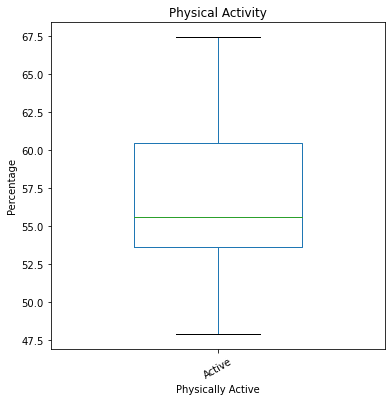

In [31]:
plt.figure(figsize=(6, 6))
plt.title('Physical Activity')
plt.xlabel('Physically Active')
plt.ylabel('Percentage')
plt1 = exercise.boxplot('Active', grid = False, rot = 30, widths = 0.5)

                            OLS Regression Results                            
Dep. Variable:                 Active   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.033
Method:                 Least Squares   F-statistic:                 9.029e-05
Date:                Wed, 05 Jan 2022   Prob (F-statistic):              0.992
Time:                        10:14:59   Log-Likelihood:                -94.981
No. Observations:                  32   AIC:                             194.0
Df Residuals:                      30   BIC:                             196.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            56.6806      3.656     15.504

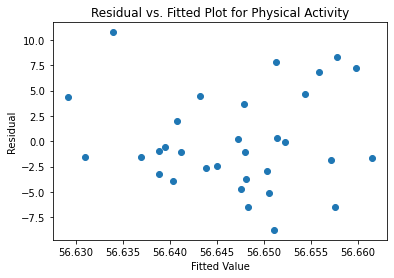

In [33]:
# Regress physical activity against NDVI

reg_model = sm.OLS(endog=exercise.Active, exog=sm.add_constant(ndvi.percent_green)).fit()
print(reg_model.summary())
plt.scatter(reg_model.fittedvalues, reg_model.resid)
plt.xlabel('Fitted Value')
plt.ylabel('Residual')
plt.title('Residual vs. Fitted Plot for Physical Activity')
plt.show()

Physical activity not significantly correlated with NDVI

### Air quality

In [48]:
# Read in air quality (from 2013)
url = 'https://github.com/ngliangwei15/CASA0007-CW3/blob/main/Data/NO2_AnnualMean_2013_PopulationData.xlsx?raw=true'
air_quality = pd.read_excel(url, sheet_name = 'Borough exceeding 40', skiprows = 4, usecols=['Borough Name', 'PopExc2013 %'])

# Drop City of London
air_quality.drop(air_quality[air_quality['Borough Name'] == 'City of London'].index, inplace = True)
air_quality = air_quality.reset_index(drop = True)


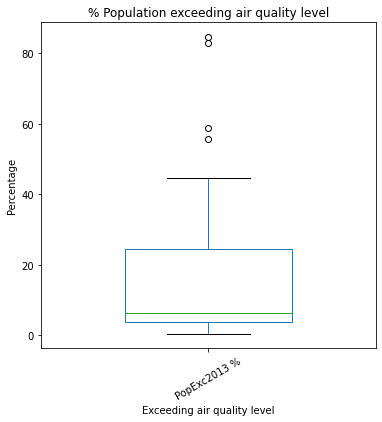

In [50]:
plt.figure(figsize=(6, 6))
plt.title('% Population exceeding air quality level')
plt.xlabel('Exceeding air quality level')
plt.ylabel('Percentage')
plt1 = air_quality.boxplot('PopExc2013 %', grid = False, rot = 30, widths = 0.5)

                            OLS Regression Results                            
Dep. Variable:           PopExc2013 %   R-squared:                       0.377
Model:                            OLS   Adj. R-squared:                  0.356
Method:                 Least Squares   F-statistic:                     18.15
Date:                Wed, 05 Jan 2022   Prob (F-statistic):           0.000186
Time:                        10:49:24   Log-Likelihood:                -138.73
No. Observations:                  32   AIC:                             281.5
Df Residuals:                      30   BIC:                             284.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            78.0252     14.349      5.438

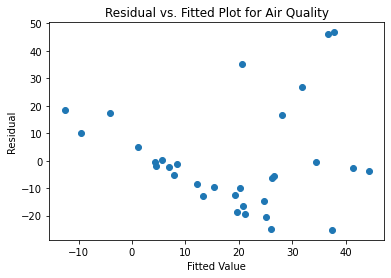

In [51]:
# Regress air quality against NDVI

reg_model = sm.OLS(endog=air_quality['PopExc2013 %'], exog=sm.add_constant(ndvi.percent_green)).fit()
print(reg_model.summary())
plt.scatter(reg_model.fittedvalues, reg_model.resid)
plt.xlabel('Fitted Value')
plt.ylabel('Residual')
plt.title('Residual vs. Fitted Plot for Air Quality')
plt.show()

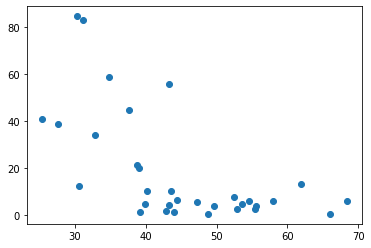

In [52]:
plt.scatter(ndvi.percent_green, air_quality['PopExc2013 %'])

Greenery has negative and significant relationship with air quality. However, there appears to be heteroskedasticity, likely because there are a lot of values near zero. Try taking log.

(array([18.,  4.,  2.,  1.,  2.,  1.,  2.,  0.,  0.,  2.]),
 array([ 0.44680671,  8.85621078, 17.26561486, 25.67501894, 34.08442302,
        42.4938271 , 50.90323118, 59.31263526, 67.72203934, 76.13144341,
        84.54084749]),
 <BarContainer object of 10 artists>)

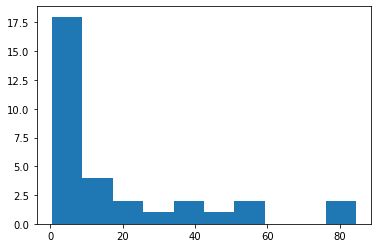

In [54]:
plt.hist(air_quality['PopExc2013 %'])

(array([2., 2., 1., 2., 9., 4., 2., 2., 4., 4.]),
 array([-0.8056292 , -0.2813428 ,  0.2429436 ,  0.76723   ,  1.29151641,
         1.81580281,  2.34008921,  2.86437561,  3.38866201,  3.91294842,
         4.43723482]),
 <BarContainer object of 10 artists>)

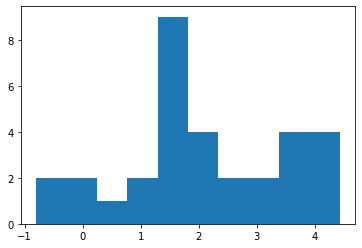

In [63]:
plt.hist(air_quality['PopExc2013 %'].apply(log))

                            OLS Regression Results                            
Dep. Variable:           PopExc2013 %   R-squared:                       0.370
Model:                            OLS   Adj. R-squared:                  0.349
Method:                 Least Squares   F-statistic:                     17.60
Date:                Wed, 05 Jan 2022   Prob (F-statistic):           0.000223
Time:                        11:05:59   Log-Likelihood:                -48.499
No. Observations:                  32   AIC:                             101.0
Df Residuals:                      30   BIC:                             103.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             5.5777      0.855      6.521

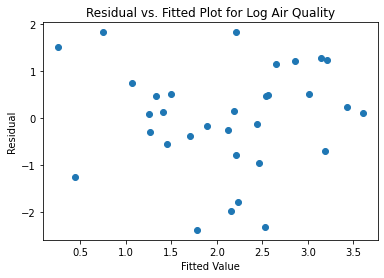

In [64]:
# Regress log air quality against NDVI

reg_model = sm.OLS(endog=air_quality['PopExc2013 %'].apply(log), exog=sm.add_constant(ndvi.percent_green)).fit()
print(reg_model.summary())
plt.scatter(reg_model.fittedvalues, reg_model.resid)
plt.xlabel('Fitted Value')
plt.ylabel('Residual')
plt.title('Residual vs. Fitted Plot for Log Air Quality')
plt.show()

Negative and significant relationship between log air quality and greenery. With homoskedasticity.

### Stress

                            OLS Regression Results                            
Dep. Variable:                Anxiety   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                 -0.009
Method:                 Least Squares   F-statistic:                    0.7343
Date:                Wed, 05 Jan 2022   Prob (F-statistic):              0.398
Time:                        11:09:45   Log-Likelihood:                -5.9201
No. Observations:                  32   AIC:                             15.84
Df Residuals:                      30   BIC:                             18.77
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             3.5964      0.226     15.907

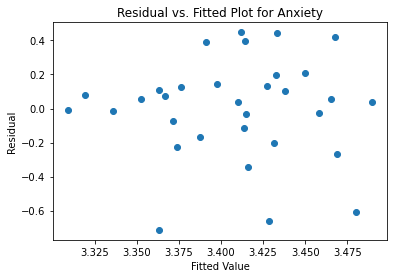

In [65]:
# Regress physical activity against NDVI

reg_model = sm.OLS(endog=wellbeing.Anxiety, exog=sm.add_constant(ndvi.percent_green)).fit()
print(reg_model.summary())
plt.scatter(reg_model.fittedvalues, reg_model.resid)
plt.xlabel('Fitted Value')
plt.ylabel('Residual')
plt.title('Residual vs. Fitted Plot for Anxiety')
plt.show()

Anxiety not significantly correlated with NDVI

## Regression 3: Happiness against NDVI and Log Air Quality

We will now regress happiness against statistically significant IV and log air quality

In [82]:
sig_var = ind_var_clean[['Good', 'percent_green']]
sig_var = sig_var.join(air_quality['PopExc2013 %'].apply(log))

In [83]:
# Drop collinear independent variables
sig_var_clean = drop_column_using_vif_(sig_var)

P-VALUE
Dropping: Good
                            OLS Regression Results                            
Dep. Variable:              Happiness   R-squared:                       0.446
Model:                            OLS   Adj. R-squared:                  0.407
Method:                 Least Squares   F-statistic:                     11.66
Date:                Wed, 05 Jan 2022   Prob (F-statistic):           0.000192
Time:                        11:40:28   Log-Likelihood:                 28.008
No. Observations:                  32   AIC:                            -50.02
Df Residuals:                      29   BIC:                            -45.62
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             6.613

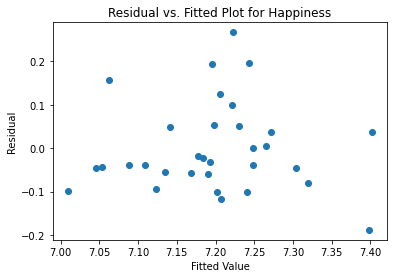

In [114]:
# Perform regression
#reg_model = back_regress_aic(wellbeing.Happiness, sig_var_clean)
reg_model = back_regress_p(wellbeing.Happiness, sig_var_clean)
#reg_model = sm.OLS(endog=wellbeing.Happiness, exog=sm.add_constant(sig_var_clean)).fit()
print(reg_model.summary())

# plot residual vs. fit
plt.scatter(reg_model.fittedvalues, reg_model.resid)
plt.xlabel('Fitted Value')
plt.ylabel('Residual')
plt.title('Residual vs. Fitted Plot for Happiness')
plt.show()


## Things to do:
- outliers
- combine the dependent and independent variables into a single df

## Placeholder

In [21]:
# Read economic inactivity and rename columns for easy reference
econ_cols = ['Code', 'Area', 'percent; Jan 2018-Dec 2018']
economic = pd.read_csv(os.path.join(os.getcwd(), 'Data', 'economic-inactivity.csv'),
                         usecols = econ_cols, 
                         low_memory = False, encoding = 'latin')
economic.rename({econ_cols[2]: 'Econ_inactive'}, axis = 1, inplace = True)

# Keep only data on London boroughs (Area Code starts with E09), drop City of London and change data type
economic.dropna(axis = 0, inplace = True)
economic = economic[economic['Code'].str.match(r'E09')].sort_values(by = ['Code'], ascending=True)
economic.drop(economic[economic.Area == 'City of London'].index, inplace = True)
economic = economic.reset_index(drop = True)
economic.Econ_inactive = economic.Econ_inactive.astype('float', copy = False)

In [22]:
# Read employment data
employ = pd.read_excel(os.path.join(os.getcwd(), 'Data', 'employment-by-occ-and-gender.xlsx'),
                       sheet_name = '2018', header = [0, 1])

# Keep only data on London boroughs (Area Code starts with E09)
employ.dropna(axis = 0, inplace = True)
employ = employ[employ['Unnamed: 0_level_0']['Code'].str.match(r'E09')]
employ.drop(employ[employ['Unnamed: 1_level_0']['Area'] == 'City of London'].index, inplace = True)
employ = employ.reset_index(drop = True)

# Create labels for the occupation types
occ = ['managers, directors and senior officials',
      'professional occupations',
      'associate prof & tech occupations',
      'administrative and secretarial occupations',
      'skilled trades occupations',
      'caring, leisure and other service occupations',
      'sales and customer service occupations',
      'process, plant and machine operatives',
      'elementary occupations']

# Compute percentage of economically active and total number of respondents as temp column
economic['Econ_active'] = 100 - economic['Econ_inactive']
economic['respondents'] = employ['% males in employment who are - 1: ' + occ[0] + ' (SOC2010)']['denominator'] + (
    employ['% females in employment who are - 1: ' + occ[0] + ' (SOC2010)']['denominator'])

# Compute number of economically active in each occupation type
for i in range(0, len(occ)):
    print(str(i+1))
    # Number of economically active
    economic[occ[i]] = employ['% males in employment who are - ' + str(i+1) + ': ' + occ[i] + ' (SOC2010)']['numerator'] + (
        employ['% females in employment who are - ' + str(i+1) + ': ' + occ[i] + ' (SOC2010)']['numerator'])
    # Percentage in each occupation type
    economic[occ[i]] = economic[occ[i]].div(economic['respondents'], axis = 0)
    economic[occ[i]] = economic[occ[i]] * economic.Econ_active


1
2
3
4
5


TypeError: unsupported operand type(s) for +: 'int' and 'str'

In [ ]:
economic